*Read section 3.3.3 (4, 5, & 6) of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

Let us continue with the car price prediction example from the previous chapter.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

In [2]:
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [3]:
# Considering the model developed to address assumptions in the previous chapter
# Model with an interaction term and a variable transformation term
ols_object = smf.ols(formula = 'np.log(price)~(year+engineSize+mileage+mpg)**2+I(mileage**2)', data = train)
model_log = ols_object.fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1834.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:57:09   Log-Likelihood:                -1173.8
No. Observations:                4960   AIC:                             2372.
Df Residuals:                    4948   BIC:                             2450.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -238.2125     25.790     -9.237      0.000    -288.773    -187.652
year                   0.1227      0.013      9.608      0.000       0.098       0.148
engineSize            13.8349      5.795      2.387      0.017       2.475      25.195
mileage                0.0005      0.000      3.837      0.000       0.000       0.001
mpg                   -1.2446      0.345     -3.610      0.000      -1.921      -0.569
year:engineSize       -0.0067      0.003     -2.324      0.020      -0.012      -0.001
year:mileage        -2.67e-07    6.8e-08     -3.923      0.000      -4e-07   -1.34e-07
year:mpg               0.0006      0.000      3.591      0.000       0.000       0.001
engineSize:mileage -2.668e-07   4.08e-07     -0.654      0.513   -1.07e-06    5.33e-07
engineSize:mpg         0.0028      0.000      6.842      0.000       0.002       0.004
mileage:mpg         7.235e-08   1.79e-08      4.036      0.000    3.72e-08    1.08e-07
I(mileage ** 2)     1.828e-11   5.64e-12      3.240      0.001    7.22e-12    2.93e-11
==============================================================================
Omnibus:                      711.514   Durbin-Watson:                   0.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2545.807
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                       6.220   Cond. No.                     1.73e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
#Computing RMSE on test data
pred_price_log = model_log.predict(testf)
np.sqrt(((testp.price - np.exp(pred_price_log))**2).mean())

9094.209473232966

## Outliers
An outlier is a point for which the true response ($y_i$) is far from the value predicted by the model. Residual plots can be used to identify outliers.

If the the response at the $i^{th}$ observation is $y_i$, the prediction is $\hat{y}_i$, then the residual $e_i$ is:

$$e_i = y_i - \hat{y_i}$$

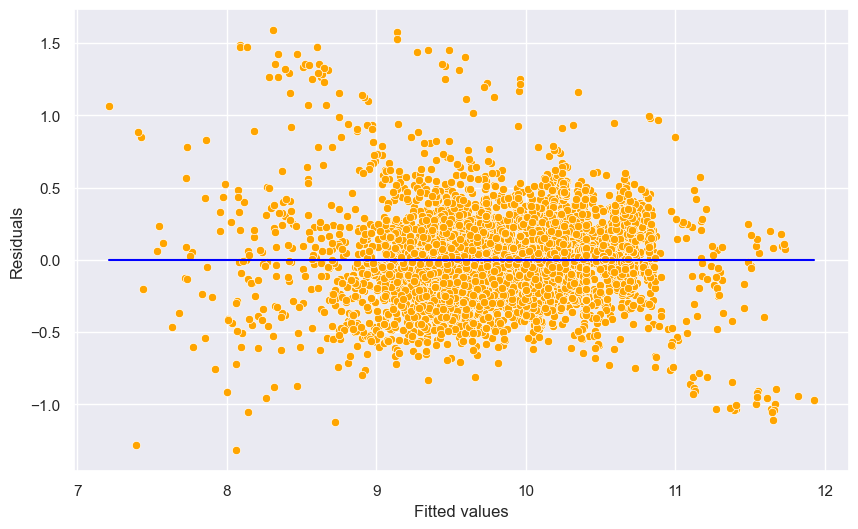

In [5]:
#Plotting residuals vs fitted values
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot(x = (model_log.fittedvalues), y=(model_log.resid),color = 'orange')
sns.lineplot(x = [model_log.fittedvalues.min(),model_log.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');

Some of the errors may be high. However, it is difficult to decide how large a residual needs to be before we can consider a point to be an outlier. To address this problem, we have standardized residuals, which are defined as:

$$r_i = \frac{e_i}{RSE(\sqrt{1-h_{ii}})},$$
where $r_i$ is the standardized residual, $RSE$ is the residual standard error, and $h_{ii}$ is the leverage *(introduced in the next section)* of the $i^{th}$ observation.

Standardized residuals, allow the residuals to be compared on a *standard scale*.

**Issue with standardized residuals:**, If the observation corresponding to the standardized residual has a high leverage, then it will drag the regression line / plane / hyperplane towards it, thereby influencing the estimate of the residual itself.

**Studentized residuals:** To address the issue with standardized residuals, studentized residual for the $i^{th}$ observation is computed as the standardized residual, but with the $RSE$ (residual standard error) computed after removing the $i^{th}$ observation from the data. Studentized residual, $t_i$ for the $i^{th}$ observation is given as:

$$t_i = \frac{e_i}{RSE_{i}(\sqrt{1-h_{ii}})},$$
where $RSE_{i}$ is the residual standard error of the model developed on the data without the $i^{th}$ observation.

**Distribution of studentized residuals:** If the regression model is appropriate such that no case is outlying because of a change in the model, then each studentized residual will follow a $t$ distribution with $(n–p–1)$ degrees of freedom. 

As the studentized residuals follow a $t$ distribution, we can conduct a hypothesis test to identify whether an observation is an outlier or not for a given sigificance level. Note that the test will be two-sided since we are not concerned with the sign of the residuals, but only their absolute values.

In the current example, for a signficance level of 5\%, the critical $t$-statistic is $t\big(1 - \frac{\alpha}{2}, n - p - 1\big)$, as calculated below.

In [7]:
n = train.shape[0]
p = model_log.df_model
alpha = 0.05

# Critical value
stats.t.ppf(1 - alpha/2, n - p - 1)

1.9604435402730618

If we were conducting the test for a single observation, we'll compare the studentized residual for that observation with the critical $t$-statistic, and if the residual is greater than the critical value, we'll consider that observation as an outlier.

However, typically, we'll be interested in conducting this test for all observations, and thus we'll need a more conservative critical value for the same signficance level. This critical value is given by the Bonferroni correction as $t\big(1 - \frac{\alpha}{2n}, n - p - 1\big)$.

Thus, the minimum value of studentized residual for which the observation will be classified as an outlier is:

In [8]:
critical_value = stats.t.ppf(1-alpha/(2*n), n - p - 1)
critical_value

4.4200129981725365

The studentized residuals can be obtained using the `outlier_test()` method of the object returned by the `fit()` method of an OLS object. Let us find the studentized residuals in our car `price` prediction model. 

In [10]:
#Studentized residuals
out = model_log.outlier_test()
out

,student_resid,unadj_p,bonf(p)
0,-1.164204,0.244398,1.0
1,-0.801879,0.422661,1.0
2,-1.263820,0.206354,1.0
3,-0.614171,0.539131,1.0
4,0.027929,0.977720,1.0
...,...,...,...
4955,-0.523361,0.600747,1.0
4956,-0.509538,0.610398,1.0
4957,-1.718808,0.085712,1.0
4958,-0.077594,0.938154,1.0


Studentized residuals are in the first column of the above table. Let us plot the studentized residuals against fitted values. In the figure below, the studentized residuals above the top dotted green line and below the bottom dotted green line are outliers.

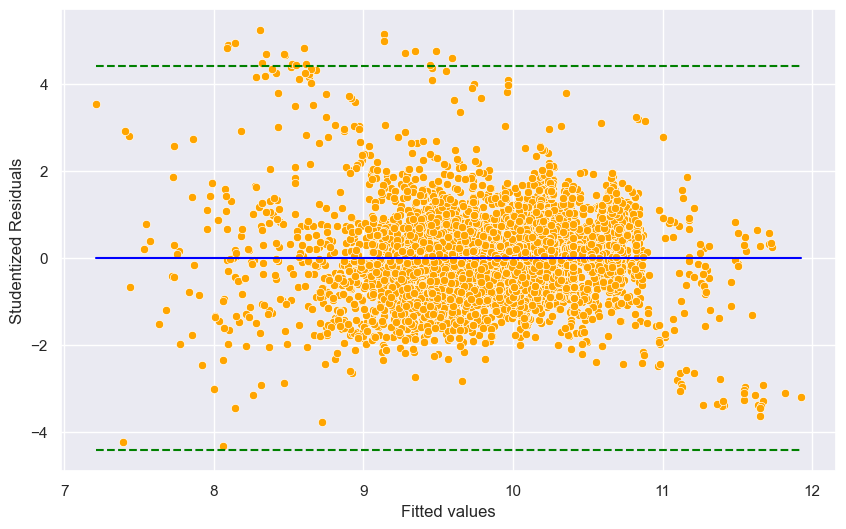

In [17]:
#Plotting studentized residuals vs fitted values
sns.scatterplot(x = (model_log.fittedvalues), y=(out.student_resid),color = 'orange')
sns.lineplot(x = [model_log.fittedvalues.min(),model_log.fittedvalues.max()],y = [0,0],color = 'blue')
ax = sns.lineplot(x = [model_log.fittedvalues.min(),model_log.fittedvalues.max()],y = [critical_value, critical_value],
             color = 'green')
sns.lineplot(x = [model_log.fittedvalues.min(),model_log.fittedvalues.max()],y = [-critical_value, -critical_value],
             color = 'green')
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals');

**Outliers:** Observations whose studentized residuals have a magnitude greater than $t\big(1 - \frac{\alpha}{2n}, n - p - 1\big)$.

**Impact of outliers:** Outliers do not have a large impact on the OLS line / plane / hyperplane as long as they don't have a high leverage *(discussed in the next section)*. However, outliers do inflate the residual standard error (RSE). RSE in turn is used to compute the standard errors of regression coefficients. As a result, statistically significant variables may appear to be insignificant, and $R^2$ may appear to be lower.

**Are there outliers in our example?**

In [21]:
#Number of points with absolute studentized residuals greater than critical_value
np.sum(np.abs(out.student_resid) > critical_value)

19

Let us analyze the outliers.

In [28]:
ind = (np.abs(out.student_resid) > critical_value)
pd.concat([train.loc[ind,:], np.exp(model_log.fittedvalues[ind])], axis = 1)

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,0
2042,18228,bmw,i3,2017,Automatic,24041,Hybrid,0,78.2726,0.0,21495,5537.337460
2046,17362,bmw,i3,2016,Automatic,68000,Hybrid,0,78.0258,0.0,15990,4107.811771
2050,19224,bmw,i3,2016,Automatic,20013,Hybrid,0,77.9310,0.0,19875,4784.986021
2051,13913,bmw,i3,2014,Automatic,34539,Hybrid,0,78.3838,0.0,14495,3269.686113
2055,16512,bmw,i3,2017,Automatic,28169,Hybrid,0,77.9799,0.0,23751,5454.207333
2059,15844,bmw,i3,2016,Automatic,19995,Hybrid,0,78.2825,0.0,19850,4773.707307
2060,12107,bmw,i3,2016,Automatic,8421,Hybrid,0,77.9125,0.0,19490,5028.048305
2061,18215,bmw,i3,2014,Automatic,37161,Hybrid,0,77.7505,0.0,14182,3259.101789
2063,15617,bmw,i3,2017,Automatic,41949,Hybrid,140,78.1907,0.0,19998,5173.402125
2064,18020,bmw,i3,2015,Automatic,9886,Hybrid,0,78.1810,0.0,17481,4214.053932


**Do you notice some unique characteristics of these observations due to which they may be outliers?**

**What methods you can propose to estimate the price of these outliers more accurately, which will also result in the overall reduction in RMSE?**

## High leverage points

High leverage points are those with an unsual value of the predictor(s). They have the potential to have a relatively higher impact on the OLS line / plane / hyperplane, as compared to the outliers. 

**Leverage statistic** (page 99 of the book): In order to quantify an observation’s leverage, we compute the leverage statistic. A large value of this statistic indicates an observation with high leverage. For simple linear regression,
\begin{equation}
h_i = \frac{1}{n} + \frac{(x_i - \bar x)^2}{\sum_{i'=1}^{n}(x_{i'} - \bar x)^2}.
\end{equation}

It is clear from this equation that $h_i$ increases with the distance of $x_i$ from $\bar x$. A large value of $h_i$ indicates that the $i^{th}$ observation is distance from the center of all the other observations in terms of predictor values.

The leverage statistic $h_i$ is always between $1/n$ and $1$, and the average leverage for all the observations is always equal to $(p+1)/n$:

\begin{equation}
\bar{h} = \frac{p+1}{n}
\end{equation}

So if a given observation has a leverage statistic that greatly exceeds $(p+1)/n$, then we may suspect that the corresponding point has high leverage.

If the $i^{th}$ observation has a large leverage $h_i$, it may exercise substantial leverage in determining the fitted value $\hat{Y}_i$, because:

- The fitted value $\hat{Y}_i$ is a linear combination of the observed $Y$ values, and $h_i$ is the weight of observation $Y_i$ in determining this fitted value.

- The larger the $h_i$, the smaller is the variance of the residual $e_i$, and the closer the fitted value $\hat{Y}_i$ will tend to be the observed value $Y_i$.

**Thumb rules:**

- A leverage $h_i$ is usually considered large if it is more than twice as large as the mean value $\bar{h}$.
- Another suggested guideline is that $h_i$ values exceeding 0.5 indicate **very high leverage**, whereas those between 0.2 and 0.5 indicate moderate leverage.

**Influential points:** Note that if a high leverage point falls in line with the regression line, then it will not affect the regression line. However, it may inflate R-squared and increase the significance of predictors. If a high leverage point falls away from the regression line, then it is also an outlier, and will affect the regression line. The points whose presence significantly affects the regression line are called influential points. A point that is both a high leverage point and an outlier is likely to be an influential point. However, a high leverage point is not necessarily an influential point.

*Source for influential points: https://online.stat.psu.edu/stat501/book/export/html/973*

Let us see if there are any high leverage points in our regression model without the predictor - `model`.

In [82]:
#Model with an interaction term and a variable transformation term
ols_object = smf.ols(formula = 'np.log(price)~(year+engineSize+mileage+mpg)**2+I(mileage**2)', data = train)
model_log = ols_object.fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1834.
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:25:59   Log-Likelihood:                -1173.8
No. Observations:                4960   AIC:                             2372.
Df Residuals:                    4948   BIC:                             2450.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -238.2125     25.790     -9.237      0.000    -288.773    -187.652
year                   0.1227      0.013      9.608      0.000       0.098       0.148
engineSize            13.8349      5.795      2.387      0.017       2.475      25.195
mileage                0.0005      0.000      3.837      0.000       0.000       0.001
mpg                   -1.2446      0.345     -3.610      0.000      -1.921      -0.569
year:engineSize       -0.0067      0.003     -2.324      0.020      -0.012      -0.001
year:mileage        -2.67e-07    6.8e-08     -3.923      0.000      -4e-07   -1.34e-07
year:mpg               0.0006      0.000      3.591      0.000       0.000       0.001
engineSize:mileage -2.668e-07   4.08e-07     -0.654      0.513   -1.07e-06    5.33e-07
engineSize:mpg         0.0028      0.000      6.842      0.000       0.002       0.004
mileage:mpg         7.235e-08   1.79e-08      4.036      0.000    3.72e-08    1.08e-07
I(mileage ** 2)     1.828e-11   5.64e-12      3.240      0.001    7.22e-12    2.93e-11
==============================================================================
Omnibus:                      711.514   Durbin-Watson:                   0.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2545.807
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                       6.220   Cond. No.                     1.73e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
#Computing the leverage statistic for each observation
influence = model_log.get_influence()
leverage = influence.hat_matrix_diag

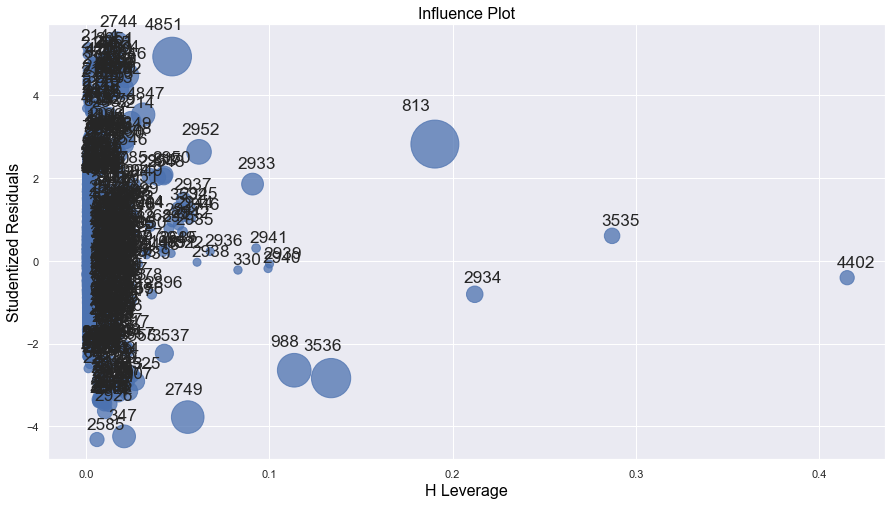

In [70]:
#Visualizng leverage against studentized residuals
sns.set(rc={'figure.figsize':(15,8)})
sm.graphics.influence_plot(model_log);

Let us identify the high leverage points in the data, as they may be affecting the regression line if they are outliers as well, i.e., if they are influential points. Note that there is no defined threshold for a point to be classified as a high leverage point. Some statisticians consider points having twice the average leverage as high leverage points, some consider points having thrice the average leverage as high leverage points, and so on.

In [84]:
out = model_log.outlier_test()

In [128]:
#Average leverage of points
average_leverage = (model_log.df_model+1)/model_log.nobs
average_leverage

0.002425222312045271

Let us consider points having four times the average leverage as high leverage points.

In [148]:
#We will remove all observations that have leverage higher than the threshold value.
high_leverage_threshold = 4*average_leverage

In [149]:
#Number of high leverage points in the dataset
np.sum(leverage>high_leverage_threshold)

196

## Influential points

Observations that are both high leverage points and outliers are influential points that may affect the regression line. Let's remove these influential points from the data and see if it improves the model prediction accuracy on test data.

In [155]:
#Dropping influential points from data
train_filtered = train.drop(np.intersect1d(np.where(np.abs(out.student_resid) > 4)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))

Note that as the Bonferroni's critical value is very conservative estimate, we have rounded off the critical value to 4, instead of 4.42.

In [156]:
train_filtered.shape

(4935, 11)

In [157]:
#Number of points removed as they were influential
train.shape[0]-train_filtered.shape[0]

25

We removed 25 influential data points from the training data.

In [159]:
#Model after removing the influential observations
ols_object = smf.ols(formula = 'np.log(price)~(year+engineSize+mileage+mpg)**2+I(mileage**2)', data = train_filtered)
model_log = ols_object.fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     2130.
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:32:30   Log-Likelihood:                -854.09
No. Observations:                4935   AIC:                             1732.
Df Residuals:                    4923   BIC:                             1810.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -247.1820     24.579    -10.057      0.000    -295.367    -198.997
year                   0.1273      0.012     10.460      0.000       0.103       0.151
engineSize            18.3749      5.492      3.346      0.001       7.609      29.141
mileage                0.0006      0.000      4.515      0.000       0.000       0.001
mpg                   -1.2885      0.327     -3.940      0.000      -1.930      -0.647
year:engineSize       -0.0090      0.003     -3.309      0.001      -0.014      -0.004
year:mileage       -3.005e-07   6.52e-08     -4.611      0.000   -4.28e-07   -1.73e-07
year:mpg               0.0006      0.000      3.890      0.000       0.000       0.001
engineSize:mileage -4.002e-07   3.88e-07     -1.032      0.302   -1.16e-06     3.6e-07
engineSize:mpg         0.0075      0.000     17.430      0.000       0.007       0.008
mileage:mpg         8.383e-08   1.69e-08      4.948      0.000    5.06e-08    1.17e-07
I(mileage ** 2)     1.742e-11   5.35e-12      3.258      0.001    6.94e-12    2.79e-11
==============================================================================
Omnibus:                      626.395   Durbin-Watson:                   0.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1852.816
Skew:                           0.672   Prob(JB):                         0.00
Kurtosis:                       5.684   Cond. No.                     1.74e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that we obtain a higher R-sqauared value of 83% as compared to 80% with the complete data. Removing the influential points helped obtain a better model fit. However, that may also happen just by reducing observations.

In [160]:
#Computing RMSE on test data
pred_price_log = model_log.predict(testf)
np.sqrt(((testp.price - np.exp(pred_price_log))**2).mean())

8813.186842472378

The RMSE on test data has also reduced. This shows that some of the influential points were impacting the regression line. With those points removed, the model better captures the general trend in the data.

## Collinearity

Collinearity refers to the situation when two or more predictor variables have a high linear association. Linear association between a pair of variables can be measured by the correlation coefficient. Thus the correlation matrix can indicate some potential collinearity problems. 

### Why and how is collinearity a problem 
*(Source:  page 100-101 of book)* 

The presence of collinearity can pose problems in the regression context, since it can be difficult to separate out the individual effects of collinear variables on the response. 

Since collinearity reduces the accuracy of the estimates of the regression coefficients, it causes the standard error for $\hat \beta_j$ to grow. Recall that the t-statistic for each predictor is calculated by dividing $\hat \beta_j$ by its standard error. Consequently, collinearity results in a decline in the $t$-statistic. As a result, **in the presence of collinearity, we may fail to reject $H_0: \beta_j = 0$. This means that the power of the hypothesis test—the probability of correctly detecting a non-zero coefficient—is reduced by collinearity.**

### How to measure collinearity/multicollinearity
*(Source: page 102 of book)* 

Unfortunately, not all collinearity problems can be detected by inspection of the correlation matrix: it is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation. We call this situation multicollinearity. Instead of inspecting the correlation matrix, a better way to assess multicollinearity is to compute the variance inflation factor (VIF). The VIF is variance inflation factor the ratio of the variance of $\hat \beta_j$ when fitting the full model divided by the variance of $\hat \beta_j$ if fit on its own. The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. Typically in practice there is a small amount of collinearity among the predictors. As a rule of thumb, a **VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity.**

The estimated variance of the coefficient $\beta_j$, of the $j^{th}$ predictor $X_j$, can be expressed as:

$$\hat{var}(\hat{\beta_j}) = \frac{(\hat{\sigma})^2}{(n-1)\hat{var}({X_j})}.\frac{1}{1-R^2_{X_j|X_{-j}}},$$

where $R^2_{X_j|X_{-j}}$ is the $R$-squared for the regression of $X_j$ on the other covariates (a regression that does not involve the response variable $Y$).

In case of simple linear regression, the variance expression in the equation above does not contain the term $\frac{1}{1-R^2_{X_j|X_{-j}}}$, as there is only one predictor. However, in case of multiple linear regression, the variance of the estimate of the $j^{th}$ coefficient ($\hat{\beta_j}$) gets inflated by a factor of $\frac{1}{1-R^2_{X_j|X_{-j}}}$ *(Note that in the complete absence of collinearity, $R^2_{X_j|X_{-j}}=0$, and the value of this factor will be 1).*

Thus, the Variance inflation factor, or the VIF for the estimated coefficient of the $j^{th}$ predictor $X_j$ is:

\begin{equation}
VIF(\hat \beta_j) = \frac{1}{1-R^2_{X_j|X_{-j}}}
\end{equation}

In [4]:
#Correlation matrix
train.corr()

,carID,year,mileage,tax,mpg,engineSize,price
carID,1.000000,0.006251,-0.001320,0.023806,-0.010774,0.011365,0.012129
year,0.006251,1.000000,-0.768058,-0.205902,-0.057093,0.014623,0.501296
mileage,-0.001320,-0.768058,1.000000,0.133744,0.125376,-0.006459,-0.478705
tax,0.023806,-0.205902,0.133744,1.000000,-0.488002,0.465282,0.144652
mpg,-0.010774,-0.057093,0.125376,-0.488002,1.000000,-0.419417,-0.369919
engineSize,0.011365,0.014623,-0.006459,0.465282,-0.419417,1.000000,0.624899
price,0.012129,0.501296,-0.478705,0.144652,-0.369919,0.624899,1.000000


Let us compute the Variance Inflation Factor (VIF) for the four predictors.

In [21]:
X = train[['mpg','year','mileage','engineSize']]

In [22]:
X.columns[1:]

Index(['year', 'mileage', 'engineSize'], dtype='object')

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

      feature           VIF
0       const  1.201579e+06
1         mpg  1.243040e+00
2        year  2.452891e+00
3     mileage  2.490210e+00
4  engineSize  1.219170e+00


As all the values of VIF are close to one, we do not have the problem of multicollinearity in the model. Note that the VIF of `year` and `mileage` is relatively high as they are the most correlated.

**Q1:** Why is the VIF of the constant so high?

**Q2:** Why do we need to include the constant while finding the VIF?

### Manual computation of VIF

In [25]:
#Manually computing the VIF for year
ols_object = smf.ols(formula = 'year~mpg+engineSize+mileage', data = train)
model_log = ols_object.fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2400.
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        02:49:19   Log-Likelihood:                -10066.
No. Observations:                4960   AIC:                         2.014e+04
Df Residuals:                    4956   BIC:                         2.017e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2018.3135      0.140   1.44e+04      0.000    2018.039    2018.588
mpg            0.0095      0.002      5.301      0.000       0.006       0.013
engineSize     0.1171      0.037      3.203      0.001       0.045       0.189
mileage    -9.139e-05   1.08e-06    -84.615      0.000   -9.35e-05   -8.93e-05
==============================================================================
Omnibus:                     2949.664   Durbin-Watson:                   1.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63773.271
Skew:                          -2.426   Prob(JB):                         0.00
Kurtosis:                      19.883   Cond. No.                     1.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [470]:
#VIF for year
1/(1-0.592)

2.4509803921568625

Note that year and mileage have a high linear correlation. Removing one of them should decrease the standard error of the coefficient of the other, without significanty decrease R-squared.

In [5]:
ols_object = smf.ols(formula = 'price~mpg+engineSize+mileage+year', data = train)
model_log = ols_object.fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     2410.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:39:45   Log-Likelihood:                -52497.
No. Observations:                4960   AIC:                         1.050e+05
Df Residuals:                    4955   BIC:                         1.050e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.661e+06   1.49e+05    -24.593      0.000   -3.95e+06   -3.37e+06
mpg          -79.3126      9.338     -8.493      0.000     -97.620     -61.006
engineSize  1.218e+04    189.969     64.107      0.000    1.18e+04    1.26e+04
mileage       -0.1474      0.009    -16.817      0.000      -0.165      -0.130
year        1817.7366     73.751     24.647      0.000    1673.151    1962.322
==============================================================================
Omnibus:                     2450.973   Durbin-Watson:                   0.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31060.548
Skew:                           2.045   Prob(JB):                         0.00
Kurtosis:                      14.557   Cond. No.                     3.83e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing mileage from the above regression.

In [7]:
ols_object = smf.ols(formula = 'price~mpg+engineSize+year', data = train)
model_log = ols_object.fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     2951.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:40:00   Log-Likelihood:                -52635.
No. Observations:                4960   AIC:                         1.053e+05
Df Residuals:                    4956   BIC:                         1.053e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.586e+06   9.78e+04    -57.098      0.000   -5.78e+06   -5.39e+06
mpg         -101.9120      9.500    -10.727      0.000    -120.536     -83.288
engineSize  1.196e+04    194.848     61.392      0.000    1.16e+04    1.23e+04
year        2771.1844     48.492     57.147      0.000    2676.118    2866.251
==============================================================================
Omnibus:                     2389.075   Durbin-Watson:                   0.528
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26920.051
Skew:                           2.018   Prob(JB):                         0.00
Kurtosis:                      13.675   Cond. No.                     1.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that the standard error of the coefficient of *year* has reduced from 73 to 48, without any large reduction in R-squared.

### When can we overlook multicollinearity?

- The severity of the problems increases with the degree of the multicollinearity. Therefore, if there is only moderate multicollinearity *(5 < VIF < 10)*, we may overlook it.

- Multicollinearity affects only the standard errors of the coefficients of collinear predictors. Therefore, if multicollinearity is not present for the predictors that we are particularly interested in, we may not need to resolve it. 

- Multicollinearity affects the standard error of the coefficients and thereby their $p$-values, but in general, it does not influence the prediction accuracy, except in the case that the coefficients are so unstable that the predictions are outside of the domain space of the response. If our sole aim is prediction, and we don’t wish to infer the statistical significance of predictors, then we may avoid addressing multicollinearity. "*The fact that some or all predictor variables are correlated among themselves does not, in general, inhibit our ability to obtain a good fit nor does it tend to affect inferences about mean responses or predictions of new observations, provided these inferences are made within the region of observations" - Neter, John, Michael H. Kutner, Christopher J. Nachtsheim, and William Wasserman. "Applied linear statistical models." (1996): 318.*